In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pi = np.pi
norm = np.linalg.norm
sq_norm = lambda x, **kw: (x ** 2).sum(**kw)

In [2]:
def draw_disc(points, edges=None, labels=True):
    """ Utility function: draws points on a poincare disk"""
    fig, ax = plt.subplots(figsize=[10, 10]) 
    for r in sorted([0, 0.25, 0.5, 0.75, 1.0], reverse=True):
        ax.add_artist(plt.Circle((0, 0), radius=r, facecolor='white', edgecolor='black'))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.add_artist(ax.scatter(*zip(*points)))
    if labels:
        for i, (x, y) in enumerate(points):
            ax.add_artist(ax.text(x + 0.0, y - 0.0, str(i), fontsize=24, 
                                  horizontalalignment='left', verticalalignment='bottom'))
        
    if edges is not None:
        for xy1, xy2 in edges:
            ax.plot([xy1[0], xy2[0]], [xy1[1], xy2[1]], color='gray')
    return ax

def reflect_at_zero(mu, x, axis=-1, eps=1e-9):
    """
    A distance-preserving transfromation of :x: to a poincare ball centered at :mu:
    :param mu: [..., 1, dim]
    :param x: [..., num_points, dim]
    """
    assert x.ndim == mu.ndim
    mu_norm = sq_norm(mu, axis=axis, keepdims=True)
    a = mu / (mu_norm + eps)
    r_squared = sq_norm(a, axis=axis, keepdims=True) - 1.0
    d_squared = sq_norm(x - a, axis=axis, keepdims=True)
    x_proj = r_squared / (d_squared + eps) * (x - a) + a
    return x_proj

def poincare_distance(x, y):
    """ Poincare distance between two vectors that are already inside the unit ball """
    return np.arccosh(1 + 2 * sq_norm(x - y, axis=-1) / (1 - norm(x, axis=-1)) / (1 - norm(y, axis=-1)))

def hyp_to_euc_dist(x):
    """ Express a hyperbolic distance in the unit disk """
    return np.sqrt((np.cosh(x) - 1.0) / (np.cosh(x) + 1.0))

In [3]:
def init_tree(num_children=2, length=1.0):
    root = np.zeros(2)
    r = hyp_to_euc_dist(length)
    alpha   = 2 * pi / num_children 
    points0 = np.zeros([num_children, 2])
    for k in range(num_children):
        angle = alpha * k
        points0[k, 0] = r * np.cos(angle)
        points0[k, 1] = r * np.sin(angle)
    return root, points0


def add_children(p, x, num_children, length=1.0):
    p0, x0 = reflect_at_zero(x, p), reflect_at_zero(x, x)
    #c : num_children
    q = norm(p0)
    
    # arg
    p_angle = np.arccos(p0[0] / q)
    if p0[1] < 0:
        p_angle = 2 * pi - p_angle
        
    alpha = 2 * pi / (num_children + 1)
    r = hyp_to_euc_dist(length)

    points0 = np.zeros([num_children, 2])
    for k in range(num_children):
        angle = p_angle + alpha * (k + 1)
        points0[k, 0] = r * np.cos(angle)
        points0[k, 1] = r * np.sin(angle)
    
    points0 = reflect_at_zero(x[None], points0)
    return points0


def make_tree(k=2, length=1.0, depth=5, leftmost_only=False):
    """ Constructs a regular tree of :depth: with :k: children and edge :length:"""
    assert depth >= 1
    root, children = init_tree(k, length)
    all_points = [root] + list(children)
    fringe = [(root, child) for child in children]
    all_edges = list(fringe)
    for i in range(depth - 1):
        new_fringe = []
        for parent, vertex in fringe:
            for child in add_children(parent, vertex, num_children=k, length=length):
                new_fringe.append((vertex, child))
                all_points.append(child)
                if leftmost_only: break
                
        fringe = new_fringe
        all_edges.extend(new_fringe)
    return np.stack(all_points), all_edges

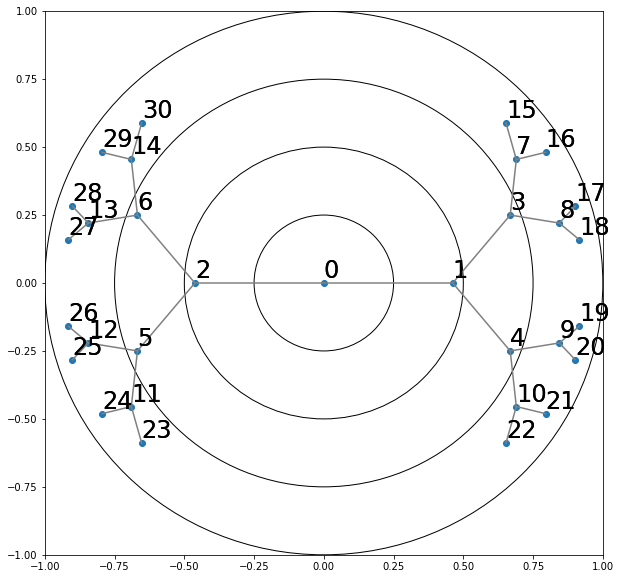

In [4]:
draw_disc(*make_tree(k=2, length=1.0, depth=4))

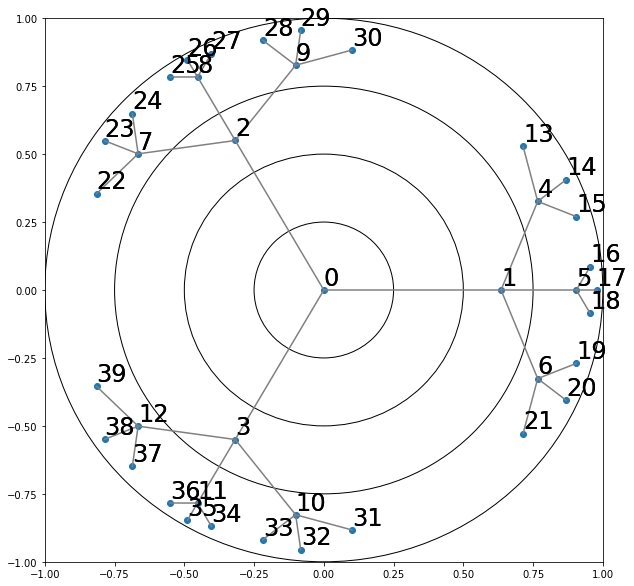

In [5]:
draw_disc(*make_tree(k=3, length=1.5, depth=3))

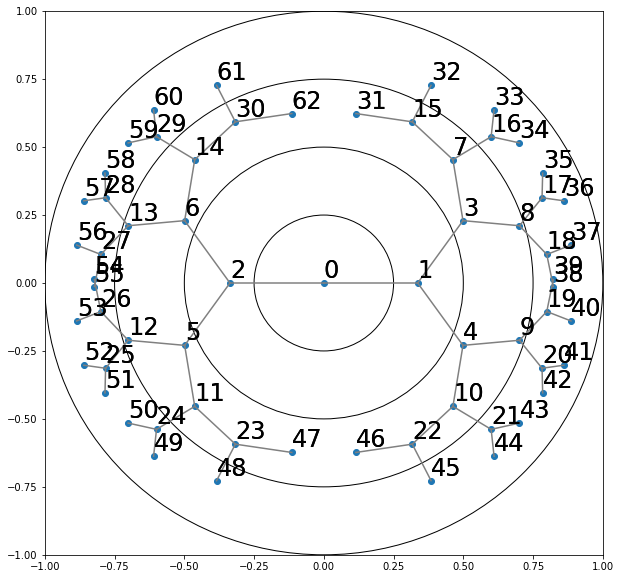

In [6]:
draw_disc(*make_tree(k=2, length=0.7, depth=5))

### Large graphs

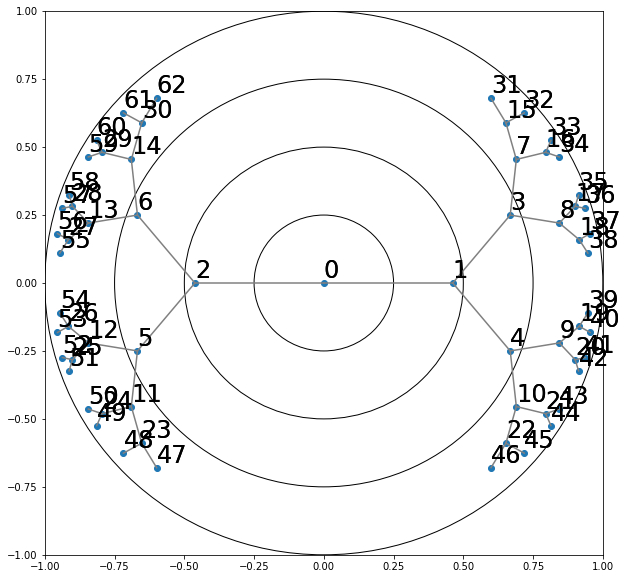

In [7]:
draw_disc(*make_tree(k=2, length=1, depth=5))
# a small tree for reference

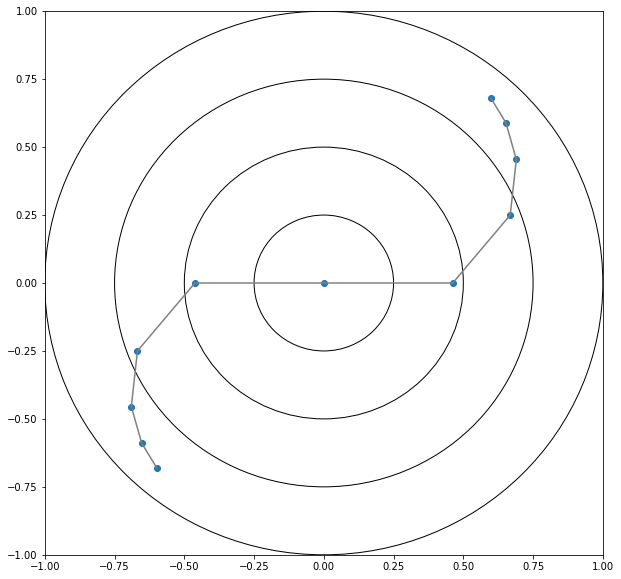

In [8]:
draw_disc(*make_tree(k=2, length=1.0, depth=5, leftmost_only=True), labels=False)
# same as previous, but only draws left children of left children of (etc)

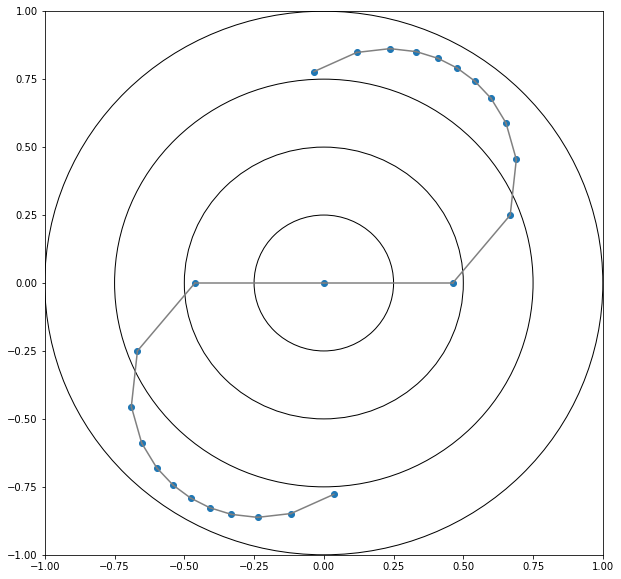

In [9]:
draw_disc(*make_tree(k=2, length=1.0, depth=12, leftmost_only=True), labels=False)
# same but deeper

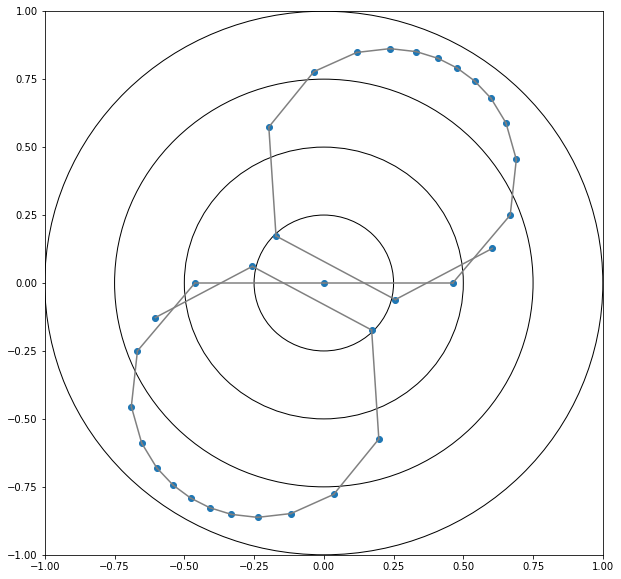

In [10]:
draw_disc(*make_tree(k=2, length=1.0, depth=16, leftmost_only=True), labels=False)
# deeper... and it starts to intersect itself

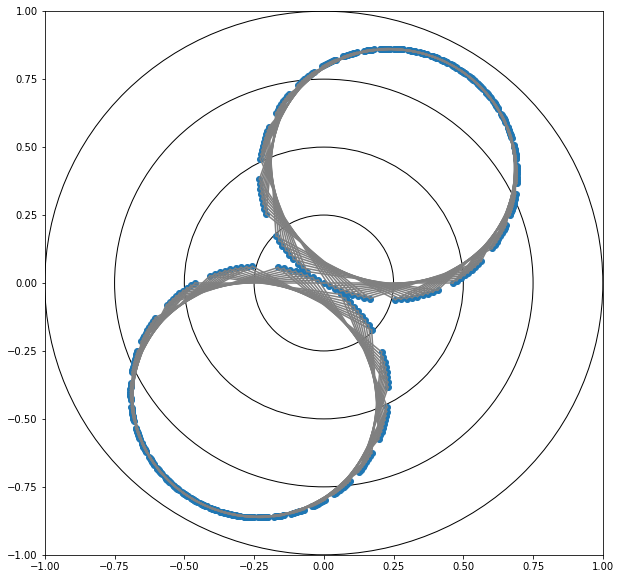

In [11]:
draw_disc(*make_tree(k=2, length=1.0, depth=256, leftmost_only=True), labels=False)
# to the point of becoming modern art

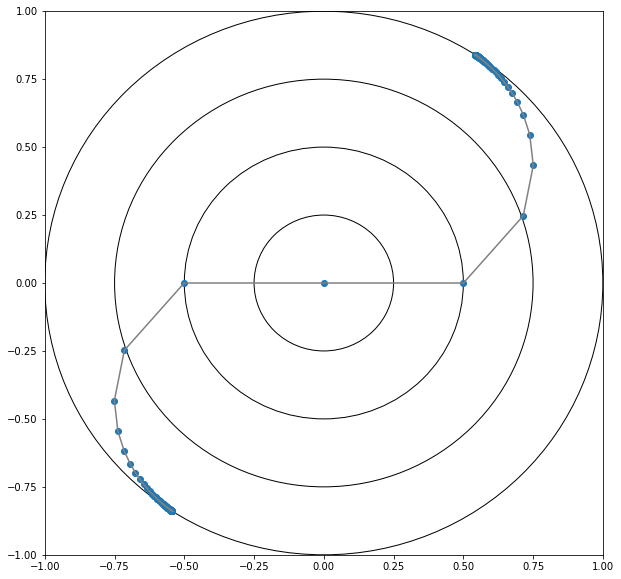

In [12]:
draw_disc(*make_tree(k=2, length=1.1, depth=256, leftmost_only=True), labels=False)
# one can fix that with longer edges aka scaling factor

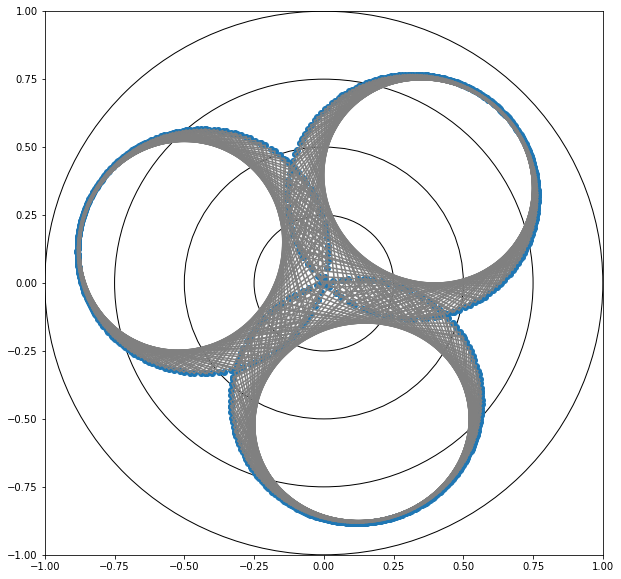

In [13]:
draw_disc(*make_tree(k=3, length=1.5, depth=256, leftmost_only=True), labels=False)
# which depends on the branching factor

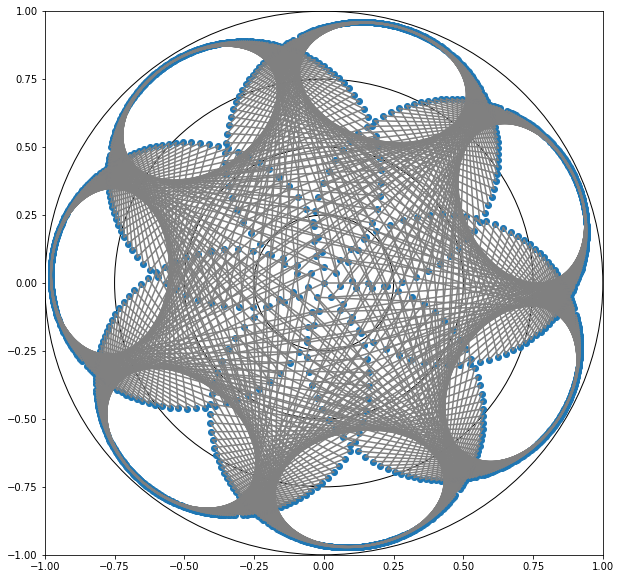

In [14]:
draw_disc(*make_tree(k=7, length=3, depth=256, leftmost_only=True), labels=False)
# have fun!